In [39]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))
import pickle as pk
import numpy as np
import pandas as pd
from pathlib import Path
import httpx
import asyncio
from rdkit import Chem

In [2]:
data_path = Path('./data/data.pkl')
with open(data_path, 'rb') as f:
    data = pk.load(f)

In [3]:
data = list(data.values())

In [4]:
data[:5]

[MolDB(id=0, smiles='CC(O)CN', mfp=None, tfp=None, inchi=None, inchi_key=None, cas='78-96-6', formula=None, mol_aweight=None, mol_eweight=None, odor_labels=None, odor_threshold=28.0, description=None, source=None, ctime=None, conformers=None, info=None),
 MolDB(id=0, smiles='CCC(=O)C(=O)O', mfp=None, tfp=None, inchi=None, inchi_key=None, cas='600-18-0', formula=None, mol_aweight=None, mol_eweight=None, odor_labels=['fatty', 'lactonic', 'sweet', 'caramellic', 'creamy'], odor_threshold=None, description=None, source=None, ctime=None, conformers=None, info=None),
 MolDB(id=0, smiles='O=C(O)CCc1ccccc1', mfp=None, tfp=None, inchi=None, inchi_key=None, cas='501-52-0', formula=None, mol_aweight=None, mol_eweight=None, odor_labels=None, odor_threshold=5.0, description=None, source=None, ctime=None, conformers=None, info=None),
 MolDB(id=0, smiles='OCc1ccc(O)cc1', mfp=None, tfp=None, inchi=None, inchi_key=None, cas='623-05-2', formula=None, mol_aweight=None, mol_eweight=None, odor_labels=['medi

In [5]:
data  = [i.model_dump() for i in data]

In [6]:
data[:2]

[{'id': 0,
  'smiles': 'CC(O)CN',
  'mfp': None,
  'tfp': None,
  'inchi': None,
  'inchi_key': None,
  'cas': '78-96-6',
  'formula': None,
  'mol_aweight': None,
  'mol_eweight': None,
  'odor_labels': None,
  'odor_threshold': 28.0,
  'description': None,
  'source': None,
  'ctime': None,
  'conformers': None,
  'info': None},
 {'id': 0,
  'smiles': 'CCC(=O)C(=O)O',
  'mfp': None,
  'tfp': None,
  'inchi': None,
  'inchi_key': None,
  'cas': '600-18-0',
  'formula': None,
  'mol_aweight': None,
  'mol_eweight': None,
  'odor_labels': ['fatty', 'lactonic', 'sweet', 'caramellic', 'creamy'],
  'odor_threshold': None,
  'description': None,
  'source': None,
  'ctime': None,
  'conformers': None,
  'info': None}]

In [11]:
from tenacity import retry, stop_after_attempt, wait_exponential

@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10))
async def get_cid(cas: str) -> int | None:
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{cas}/cids/JSON/"

    async with httpx.AsyncClient(timeout=30.0) as client:
        response = await client.get(url)
        response.raise_for_status()  # 若状态码非 200 会抛异常
        data = response.json()
        cids = data.get('IdentifierList', {}).get('CID', [])
        return int(cids[0]) if cids else None

@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10))
async def fetch_by_cid(cid: int) -> dict:
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cid}/JSON/"

    async with httpx.AsyncClient(timeout=30.0) as client:
        response = await client.get(url)
        response.raise_for_status()  # 若状态码非 200 会抛异常
        data = response.json()
        return data


def find_dict_by_key_value(data, target_key, target_value):
    """
    在嵌套字典中查找符合特定key:value条件的字典
    
    参数:
        data: 要搜索的字典或列表
        target_key: 要匹配的键
        target_value: 要匹配的值
    
    返回:
        第一个匹配的字典，如果没有找到则返回None
    """
    if isinstance(data, dict):
        # 检查当前字典是否匹配
        if target_key in data and data[target_key] == target_value:
            return data
        # 递归检查字典的值
        for value in data.values():
            result = find_dict_by_key_value(value, target_key, target_value)
            if result is not None:
                return result
    elif isinstance(data, list):
        # 如果是列表，递归检查每个元素
        for item in data:
            result = find_dict_by_key_value(item, target_key, target_value)
            if result is not None:
                return result
    return None


def find_value_by_key(data, target_key):
    """
    在嵌套字典中查找指定key的第一个匹配值
    
    参数:
        data: 要搜索的字典或列表
        target_key: 要查找的键
    
    返回:
        第一个匹配的value，如果没有找到则返回None
    """
    if isinstance(data, dict):
        # 检查当前字典是否包含目标key
        if target_key in data:
            return data[target_key]
        # 递归检查字典的值
        for value in data.values():
            result = find_value_by_key(value, target_key)
            if result is not None:
                return result
    elif isinstance(data, list):
        # 如果是列表，递归检查每个元素
        for item in data:
            result = find_value_by_key(item, target_key)
            if result is not None:
                return result
    return None


def get_fema(data:dict) -> int | None:
    fema_dict = find_dict_by_key_value(data, 'Name', 'FEMA Number')
    if fema_dict is not None:
        fema_value = fema_dict.get('Value', {}).get('StringWithMarkup', [{}])[0].get('String', '')
        return int(fema_value)
    return None

def get_iupac(data:dict) -> str | None:
    iupac_dict = find_dict_by_key_value(data, 'TOCHeading', 'IUPAC Name')
    if iupac_dict is not None:
        iupac_value = iupac_dict.get('Information', [{}])[0].get("Value",{}).get('StringWithMarkup', [{}])[0].get('String', '')
        return iupac_value
    return None

def get_smiles(data:dict) -> str | None:
    smiles_dict = find_dict_by_key_value(data, 'TOCHeading', 'SMILES')
    if smiles_dict is not None:
        smiles = smiles_dict.get('Information', [{}])[0].get("Value",{}).get('StringWithMarkup', [{}])[0].get('String', '')
        return smiles
    return None

    

In [8]:
cid = await get_cid('106-22-9')
cid

8842

In [9]:
data = await fetch_by_cid(cid)
data

{'Record': {'RecordType': 'CID',
  'RecordNumber': 8842,
  'RecordTitle': 'Citronellol',
  'Section': [{'TOCHeading': 'Structures',
    'Description': 'Structure depictions of this compound, including computationally generated two-dimensional (2D) and three-dimensional (3D) structures, as well as experimentally determined 3D single-crystal structures.',
    'Section': [{'TOCHeading': '2D Structure',
      'Description': 'A two-dimensional (2D) structure representation of the compound.  Because this structure is processed through chemical structure standardization (Hähnke et al., J. Cheminform. 2018, 10, 36), it is not necessarily the same as the structures provided by individual data contributors.  ',
      'URL': 'https://doi.org/10.1186/s13321-018-0293-8',
      'DisplayControls': {'MoveToTop': True},
      'Information': [{'ReferenceNumber': 78, 'Value': {'Boolean': [True]}}]},
     {'TOCHeading': '3D Conformer',
      'Description': 'A three-dimensional (3D) structure representatio

In [13]:
smi = get_smiles(data)
smi

'CC(CCC=C(C)C)CCO'

In [18]:
res = await fetch_by_cid(239)

RetryError: RetryError[<Future at 0x11a3bada0 state=finished raised UnicodeDecodeError>]

In [ ]:
semaphore = asyncio.Semaphore(40) 
error_list=[]

async def process(m:dict,index:int):
    async with semaphore:
        if m['cas'] is None:
            return None

        cid=None
        try:
            cid = await get_cid(m['cas'])
            if cid is None:
                return None
            data = await fetch_by_cid(cid)
            fema = get_fema(data)
            iupac = get_iupac(data)
            m['fema'] = fema if fema is not None else None
            m['iupac'] = iupac if iupac is not None else None
            print(f"Processed CAS: {m['cas']}, CID: {cid}, FEMA: {fema}, IUPAC: {iupac}")
        except Exception:
            error_list.append({
                'index':index,
                'cas': m['cas'],
                'cid': cid
            })
            print(f"Error processing Index: {index}, CAS: {m['cas']}, CID: {cid}")

task  = [process(val,index) for index,val in enumerate(data)]
await asyncio.gather(*task)

In [15]:
task  = [process(val,index) for index,val in enumerate(data)]
await asyncio.gather(*task)


Processed CAS: 124-13-0, CID: 454, FEMA: 2797, IUPAC: octanal
Processed CAS: 513-86-0, CID: 179, FEMA: 2008, IUPAC: 3-hydroxybutan-2-one
Processed CAS: 646-01-5, CID: 563, FEMA: None, IUPAC: 3-methylsulfanylpropanoic acid
Processed CAS: 122-03-2, CID: 326, FEMA: 2341, IUPAC: 4-propan-2-ylbenzaldehyde
Processed CAS: 123-08-0, CID: 126, FEMA: 3984, IUPAC: 4-hydroxybenzaldehyde
Processed CAS: 431-03-8, CID: 650, FEMA: 2370, IUPAC: butane-2,3-dione
Processed CAS: 67-64-1, CID: 180, FEMA: 3326, IUPAC: propan-2-one
Processed CAS: 600-18-0, CID: 58, FEMA: 3723, IUPAC: 2-oxobutanoic acid
Processed CAS: 50-21-5, CID: 612, FEMA: 2611, IUPAC: 2-hydroxypropanoic acid
Processed CAS: 64-18-6, CID: 284, FEMA: 2487, IUPAC: formic acid
Processed CAS: 536-60-7, CID: 325, FEMA: 2933, IUPAC: (4-propan-2-ylphenyl)methanol
Processed CAS: 328-39-2, CID: 857, FEMA: None, IUPAC: 2-amino-4-methylpentanoic acid
Processed CAS: 99-96-7, CID: 135, FEMA: 3986, IUPAC: 4-hydroxybenzoic acid
Processed CAS: 123-38-6, CI

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [28]:
len(error_list)

29

In [26]:
data[2702]

{'id': 0,
 'smiles': 'C=C(C)C1CC=C(C)C(OC(=O)CC(C)C)C1',
 'mfp': None,
 'tfp': None,
 'inchi': None,
 'inchi_key': None,
 'cas': '94386-39-7',
 'formula': None,
 'mol_aweight': None,
 'mol_eweight': None,
 'odor_labels': ['sweet', 'fruity', 'herbal'],
 'odor_threshold': None,
 'description': None,
 'source': None,
 'ctime': None,
 'conformers': None,
 'info': None}

In [21]:
data[4991]['fema'] = None
data[4991]['iupac'] = "4-[(E)-4-(4-hydroxyphenyl)hex-3-en-3-yl]phenol"
data[4991]

{'id': 0,
 'smiles': 'CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1',
 'mfp': None,
 'tfp': None,
 'inchi': None,
 'inchi_key': None,
 'cas': '56-53-1',
 'formula': None,
 'mol_aweight': None,
 'mol_eweight': None,
 'odor_labels': None,
 'odor_threshold': 2.3,
 'description': None,
 'source': None,
 'ctime': None,
 'conformers': None,
 'info': None,
 'fema': None,
 'iupac': '4-[(E)-4-(4-hydroxyphenyl)hex-3-en-3-yl]phenol'}

In [30]:
with open('./data/data_post.pkl','wb') as f:
    pk.dump(data, f)

In [27]:
error_list= [i for i in error_list if i['cid'] is None]
error_list

[{'index': 1038, 'cas': '13679-86-2', 'cid': None},
 {'index': 1087, 'cas': '62532-51-8', 'cid': None},
 {'index': 1395, 'cas': '67879-60-1', 'cid': None},
 {'index': 1469, 'cas': '68258-95-7', 'cid': None},
 {'index': 1699, 'cas': '93762-35-7', 'cid': None},
 {'index': 1742, 'cas': '10321-71-8', 'cid': None},
 {'index': 2096, 'cas': '29725-66-4', 'cid': None},
 {'index': 2702, 'cas': '94386-39-7', 'cid': None},
 {'index': 2864, 'cas': '79930-37-3', 'cid': None},
 {'index': 2853, 'cas': '17671-25-9', 'cid': None},
 {'index': 3189, 'cas': '479547-57-4', 'cid': None},
 {'index': 3226, 'cas': '60766-00-9', 'cid': None},
 {'index': 3292, 'cas': '83418-54-6', 'cid': None},
 {'index': 3507, 'cas': '586-81-2', 'cid': None},
 {'index': 3604, 'cas': '9000-11-7', 'cid': None},
 {'index': 4107, 'cas': '68611-23-4', 'cid': None},
 {'index': 4109, 'cas': '68908-82-7', 'cid': None},
 {'index': 4106, 'cas': '68585-09-1', 'cid': None},
 {'index': 4184, 'cas': '58214-97-4', 'cid': None},
 {'index': 422

In [29]:
for i in error_list:
    data[i['index']]['fema'] = None
    data[i['index']]['iupac'] = None



In [ ]:
semaphore = asyncio.Semaphore(10) 
error_list2=[]

async def process(m:dict):
    async with semaphore:
        cid=None
        try:
            cid = await get_cid(m['cas'])
            if cid is None:
                return None
            data = await fetch_by_cid(cid)
            fema = get_fema(data)
            iupac = get_iupac(data)
            m['fema'] = fema if fema is not None else None
            m['iupac'] = iupac if iupac is not None else None
            print(f"Processed CAS: {m['cas']}, CID: {cid}, FEMA: {fema}, IUPAC: {iupac}")
        except Exception:
            error_list.append({
                'cas': m['cas'],
                'cid': cid
            })
            print(f"Error processing CAS: {m['cas']}, CID: {cid}")

In [17]:
cas_list= [i['cas'] for i in data]
set1=set(cas_list)
len(set1), len(data)

(4968, 5591)

In [11]:
data [:6]

[{'id': 0,
  'smiles': 'CC(O)CN',
  'mfp': None,
  'tfp': None,
  'inchi': None,
  'inchi_key': None,
  'cas': '78-96-6',
  'formula': None,
  'mol_aweight': None,
  'mol_eweight': None,
  'odor_labels': None,
  'odor_threshold': 28.0,
  'description': None,
  'source': None,
  'ctime': None,
  'conformers': None,
  'info': None},
 {'id': 0,
  'smiles': 'CCC(=O)C(=O)O',
  'mfp': None,
  'tfp': None,
  'inchi': None,
  'inchi_key': None,
  'cas': '600-18-0',
  'formula': None,
  'mol_aweight': None,
  'mol_eweight': None,
  'odor_labels': ['fatty', 'lactonic', 'sweet', 'caramellic', 'creamy'],
  'odor_threshold': None,
  'description': None,
  'source': None,
  'ctime': None,
  'conformers': None,
  'info': None,
  'fema': 3723,
  'iupac': '2-oxobutanoic acid'},
 {'id': 0,
  'smiles': 'O=C(O)CCc1ccccc1',
  'mfp': None,
  'tfp': None,
  'inchi': None,
  'inchi_key': None,
  'cas': '501-52-0',
  'formula': None,
  'mol_aweight': None,
  'mol_eweight': None,
  'odor_labels': None,
  'odor_

In [ ]:
for m in data:
    d = await fetch_by_cid(m['cid'])
    m['fema'] = get_fema(d)
    m['iupac'] = get_iupac(d)



In [8]:
import pubchempy as pcp
import re

# 1. 你的 SMILES
smiles = 'CC(O)CN'   # 例：布洛芬

# 2. 根据 SMILES 获取 PubChem 化合物对象
compounds = pcp.get_compounds(smiles, namespace='smiles', as_dataframe=False)
if not compounds:
    raise ValueError('SMILES 在 PubChem 中未找到')
c = compounds[0]

In [12]:
c.cid

4

In [17]:
data = await fetch_pubchem(c.cid)

In [22]:
get_fema(data)

3965

In [24]:
get_iupac(data)

'1-aminopropan-2-ol'

In [13]:
await fetch_pubchem(c.cid)

{'Record': {'RecordType': 'CID',
  'RecordNumber': 4,
  'RecordTitle': '1-Amino-2-propanol',
  'Section': [{'TOCHeading': 'Structures',
    'Description': 'Structure depictions of this compound, including computationally generated two-dimensional (2D) and three-dimensional (3D) structures, as well as experimentally determined 3D single-crystal structures.',
    'Section': [{'TOCHeading': '2D Structure',
      'Description': 'A two-dimensional (2D) structure representation of the compound.  Because this structure is processed through chemical structure standardization (Hähnke et al., J. Cheminform. 2018, 10, 36), it is not necessarily the same as the structures provided by individual data contributors.  ',
      'URL': 'https://doi.org/10.1186/s13321-018-0293-8',
      'DisplayControls': {'MoveToTop': True},
      'Information': [{'ReferenceNumber': 83, 'Value': {'Boolean': [True]}}]},
     {'TOCHeading': '3D Conformer',
      'Description': 'A three-dimensional (3D) structure represent

In [2]:
import pandas as pd

# 读取 CSV 文件
df = pd.read_csv("./data/dataset_7209_withSource_andIFRA.csv")

# 去除 cas 为空或缺失的行
df = df[df['cas'].notna()]              # 去掉 NaN
df = df[df['cas'].astype(str).str.strip() != ""]  # 去掉空字符串

# 找出重复的 cas 值
duplicate_cas = df[df.duplicated('cas', keep=False)]

# 按 cas 排序方便查看
duplicate_groups = duplicate_cas.sort_values('cas')

# 输出结果
print(duplicate_groups)

# 可选：保存到新文件
duplicate_groups.to_csv("duplicate_cas_records.csv", index=False)


                                        smiles         cas  \
3478              CCCCCC/C(=C\C1=CC=CC=C1)/C=O    101-86-0   
3599                    CCCCCCC(C=O)=Cc1ccccc1    101-86-0   
4921                   COC(=O)/C=C/C1=CC=CC=C1    103-26-4   
4959                        COC(=O)C=Cc1ccccc1    103-26-4   
4459                     CCOC(=O)/C=C/c1ccccc1    103-36-6   
...                                        ...         ...   
2466                      CC=Cc1ccc(OCC)c(O)c1     94-86-0   
1260  CC1=CC(=O)[C@@H](CC1)[C@](C)(CCC=C(C)C)O  95602-94-1   
1174          CC1=CC(=O)C(CC1)C(C)(CCC=C(C)C)O  95602-94-1   
2457                       CC=Cc1ccc(O)c(OC)c1     97-54-1   
40                       C/C=C/c1ccc(O)c(OC)c1     97-54-1   

                                                  iupac    fema  \
3478                          (2E)-2-benzylideneoctanal  2569.0   
3599                          (2E)-2-benzylideneoctanal  2569.0   
4921                   methyl (E)-3-phenylprop-2-enoat

In [3]:
duplicate_groups

,smiles,cas,iupac,fema,odor_labels,odor_threshold,canonical_smiles,source,IFRA_name,IFRA
3478,CCCCCC/C(=C\C1=CC=CC=C1)/C=O,101-86-0,(2E)-2-benzylideneoctanal,2569.0,sweet,NaN,CCCCCC/C(C=O)=C\c1ccccc1,FlavorDB,"""alpha-Hexyl cinnamic aldehyde""",Restriction
3599,CCCCCCC(C=O)=Cc1ccccc1,101-86-0,(2E)-2-benzylideneoctanal,2569.0,"fresh,herbal,floral,green,sweet,jasmin,waxy",NaN,CCCCCCC(C=O)=Cc1ccccc1,GS-LF,"""alpha-Hexyl cinnamic aldehyde""",Restriction
4921,COC(=O)/C=C/C1=CC=CC=C1,103-26-4,methyl (E)-3-phenylprop-2-enoate,2698.0,sweet,NaN,COC(=O)/C=C/c1ccccc1,FlavorDB,NaN,NaN
4959,COC(=O)C=Cc1ccccc1,103-26-4,methyl (E)-3-phenylprop-2-enoate,2698.0,"cherry,fruity,sweet,cinnamon,strawberry,balsamic",NaN,COC(=O)C=Cc1ccccc1,GS-LF,NaN,NaN
4459,CCOC(=O)/C=C/c1ccccc1,103-36-6,ethyl (E)-3-phenylprop-2-enoate,2430.0,sweet,0.017,CCOC(=O)/C=C/c1ccccc1,Threshold,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2466,CC=Cc1ccc(OCC)c(O)c1,94-86-0,2-ethoxy-5-[(E)-prop-1-enyl]phenol,2922.0,"phenolic,powdery,woody,vanilla,sweet,tobacco,s...",NaN,CC=Cc1ccc(OCC)c(O)c1,GS-LF,"""Propenylguaethol""",Restriction
1260,CC1=CC(=O)[C@@H](CC1)[C@](C)(CCC=C(C)C)O,95602-94-1,(6S)-6-[(2S)-2-hydroxy-6-methylhept-5-en-2-yl]...,NaN,"sweet,creamy,fruity",NaN,CC(C)=CCC[C@](C)(O)[C@@H]1CCC(C)=CC1=O,FlavorDB,NaN,NaN
1174,CC1=CC(=O)C(CC1)C(C)(CCC=C(C)C)O,95602-94-1,(6S)-6-[(2S)-2-hydroxy-6-methylhept-5-en-2-yl]...,NaN,sweet,NaN,CC(C)=CCCC(C)(O)C1CCC(C)=CC1=O,FlavorDB,NaN,NaN
2457,CC=Cc1ccc(O)c(OC)c1,97-54-1,2-methoxy-4-[(E)-prop-1-enyl]phenol,2468.0,"clove,phenolic,floral,sweet,spicy",NaN,CC=Cc1ccc(O)c(OC)c1,GS-LF,"""Isoeugenol""",Restriction


In [1]:
import pandas as pd
from rdkit import Chem

In [89]:
data = pd.read_csv('251105_merged_output.csv')

In [90]:
data.columns

Index(['smiles', 'cas', 'iupac', 'fema', 'odor_labels', 'odor_threshold',
       'source', 'IFRA_name', 'IFRA'],
      dtype='object')

In [91]:
data.notna().sum()


smiles            7111
cas               6517
iupac             6461
fema              2093
odor_labels       6464
odor_threshold    1167
source            7111
IFRA_name          213
IFRA               192
dtype: int64

In [3]:
cas_in_db = data['smiles'].to_list()
cas_in_db[:5]

['C[C@H]1[C@H]2CC[C@@H]3[C@@]2(CC[C@H]4[C@H]3CC=C5[C@@]4(CC[C@@H](C5)N(C)C)C)CN1C.Br.Br',
 'CN1CCC=C(C1)C(=O)OC.Br',
 'BrC(Br)Br',
 'BrC(Br)I',
 'BrC=Cc1ccccc1']

In [4]:
def count_EZ_in_smiles(smiles_list):
    potential_EZ_count = 0
    explicit_EZ_count = 0

    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue

        Chem.AssignStereochemistry(mol, force=True, cleanIt=True)

        has_potential = False
        has_explicit = False

        for bond in mol.GetBonds():
            if bond.GetBondType() != Chem.rdchem.BondType.DOUBLE:
                continue

            a1, a2 = bond.GetBeginAtom(), bond.GetEndAtom()
            # 判断是否具有潜在E/Z构型
            n1 = [nbr.GetIdx() for nbr in a1.GetNeighbors() if nbr.GetIdx() != a2.GetIdx()]
            n2 = [nbr.GetIdx() for nbr in a2.GetNeighbors() if nbr.GetIdx() != a1.GetIdx()]
            if len(set(n1)) >= 1 and len(set(n2)) >= 1:
                has_potential = True

            # 判断是否明确标记E/Z
            stereo = bond.GetStereo()
            if stereo in (Chem.rdchem.BondStereo.STEREOE, Chem.rdchem.BondStereo.STEREOZ):
                has_explicit = True

        if has_potential:
            potential_EZ_count += 1
        if has_explicit:
            explicit_EZ_count += 1

    return potential_EZ_count, explicit_EZ_count


In [5]:


potential, explicit = count_EZ_in_smiles(cas_in_db)
print(f"具有潜在E/Z构型的分子数: {potential}")
print(f"明确标注E/Z的分子数: {explicit}")

具有潜在E/Z构型的分子数: 1881
明确标注E/Z的分子数: 168


[16:39:12] WARNING: not removing hydrogen atom without neighbors
[16:39:12] WARNING: not removing hydrogen atom without neighbors
[16:39:12] WARNING: not removing hydrogen atom without neighbors
[16:39:12] WARNING: not removing hydrogen atom without neighbors


In [20]:
count_with_chiral_centers = 0   # 包括未指定的
count_with_defined_chirality = 0  # 明确 R/S

for smi in cas_in_db:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    
    # 检查是否有手性中心（包括未指定的）
    centers_all = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
    if len(centers_all) > 0:
        count_with_chiral_centers += 1
    
    # 检查是否有明确手性中心（只算指定了 R/S）
    centers_defined = Chem.FindMolChiralCenters(mol, includeUnassigned=False)
    if len(centers_defined) > 0:
        count_with_defined_chirality += 1

print(f"有手性中心的分子数量（含未指定R/S）: {count_with_chiral_centers}")
print(f"明确有手性的分子数量（指定了R/S）: {count_with_defined_chirality}")

有手性中心的分子数量（含未指定R/S）: 3318
明确有手性的分子数量（指定了R/S）: 944


[17:30:14] WARNING: not removing hydrogen atom without neighbors
[17:30:14] WARNING: not removing hydrogen atom without neighbors
[17:30:14] WARNING: not removing hydrogen atom without neighbors
[17:30:14] WARNING: not removing hydrogen atom without neighbors


In [12]:
cas_check = [
'60-12-8',
'106-24-1',
'89-78-1',
'14073-97-3',
'491-07-6',
'20053-88-7',
]


In [13]:
for cas in cas_check:
    print(cas in cas_in_db)

False
True
False
False
False
False


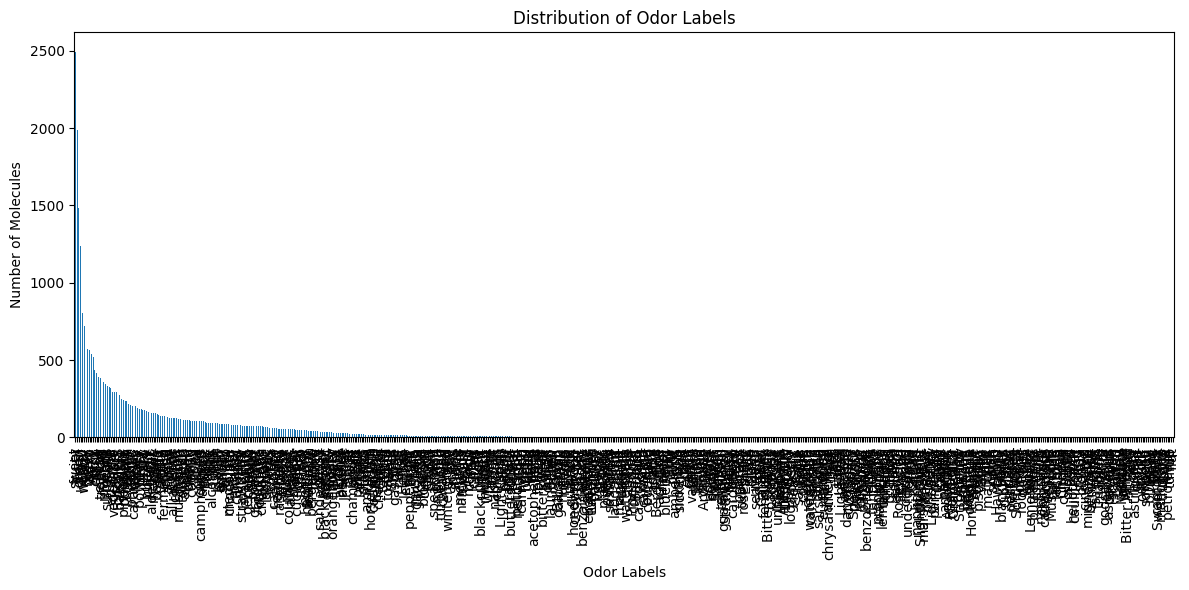

In [62]:
import matplotlib.pyplot as plt

# 取统计结果（odor_counts）
odor_counts = odor_exploded.value_counts()

# 画图
plt.figure(figsize=(12, 6))
odor_counts.plot(kind='bar')

plt.xlabel("Odor Labels")
plt.ylabel("Number of Molecules")
plt.title("Distribution of Odor Labels")
plt.xticks(rotation=90)  # x轴标签旋转，避免重叠
plt.tight_layout()       # 自动调整布局
plt.show()


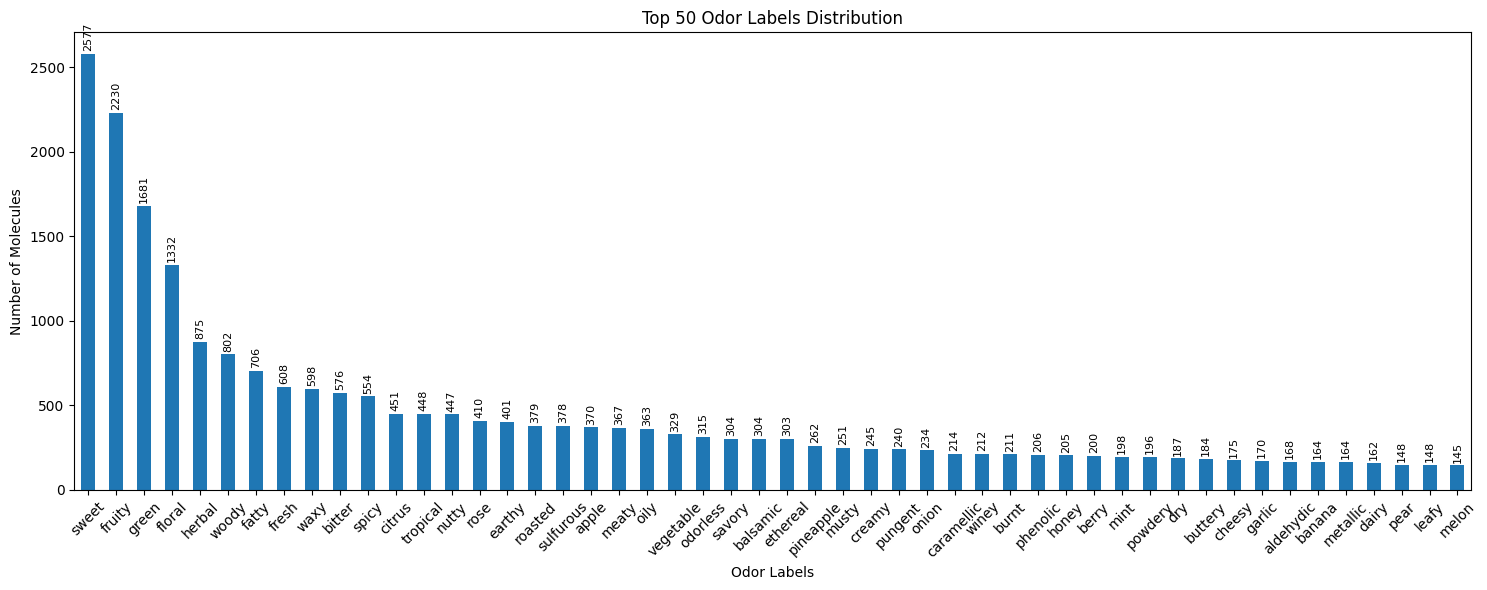

In [79]:
top_n = 50
fig, ax = plt.subplots(figsize=(top_n * 0.3, 6))  # 创建图和坐标轴对象

bars = odor_counts.head(top_n).plot(kind='bar', ax=ax)
plt.xlabel("Odor Labels")
plt.ylabel("Number of Molecules")
plt.title(f"Top {top_n} Odor Labels Distribution")
plt.xticks(rotation=45)
ax.bar_label(bars.containers[0], label_type='edge', fontsize=8, rotation=90, padding=2)
plt.tight_layout()
plt.savefig("odor_distribution.svg", format="svg")
plt.show()

<Figure size 640x480 with 0 Axes>

In [13]:
cas = [i for i in data['cas'] if i and i != 'nan']
print(len(cas))

6910


In [16]:
type(cas[1797])

float

In [14]:
for i,v in  enumerate(cas):
     print(i,v)

0 78-96-6
1 600-18-0
2 501-52-0
3 623-05-2
4 123-08-0
5 99-96-7
6 64-19-7
7 75-07-0
8 513-86-0
9 67-64-1
10 124-04-9
11 100-52-7
12 65-85-0
13 100-51-6
14 123-72-8
15 71-36-3
16 107-92-6
17 64-18-6
18 77-92-9
19 536-60-7
20 122-03-2
21 7786-61-0
22 95-48-7
23 108-39-4
24 124-07-2
25 124-13-0
26 90-05-1
27 6915-15-7
28 123-38-6
29 646-01-5
30 50-21-5
31 431-03-8
32 119-84-6
33 96-26-4
34 64-17-5
35 79-14-1
36 120-72-9
37 328-39-2
38 526-83-0
39 59-51-8
40 74-93-1
41 78-98-8
42 91-20-3
43 111-87-5
44 1113-60-6
45 57-10-3
46 150-30-1
47 108-95-2
48 156-06-9
49 122-78-1
50 103-82-2
51 64-04-0
52 57-55-6
53 71-23-8
54 79-09-4
55 110-86-1
56 127-17-3
57 75-18-3
58 110-15-6
59 110-01-0
60 137-00-8
61 1184-78-7
62 75-50-3
63 516-06-3
64 121-33-5
65 1490-04-6
66 89-86-1
67 498-02-2
68 120-51-4
69 622-78-6
70 58-08-2
71 76-22-2
72 36653-82-4
73 470-82-6
74 106-44-5
75 334-48-5
76 2444-46-4
77 119-61-9
78 97-53-0
79 111-30-8
80 499-44-5
81 67-63-0
82 143-07-7
83 119-36-8
84 607-91-0
85 108-46-3
8

In [1]:
import pandas as pd

In [14]:
df = pd.read_csv('./data/odor_translated.csv')

In [18]:
data_dict = df.to_dict(orient='records')
data_dict

[{'cas': '106-22-9', 'odor': 'Rose, Fresh, Light Citrus'},
 {'cas': '150-84-5', 'odor': 'Rose, Fresh, Light Citrus'},
 {'cas': '13477-62-8', 'odor': 'Rose, Fresh, Light Citrus'},
 {'cas': '106-24-1', 'odor': 'Rose, Fresh, Light Citrus'},
 {'cas': '16409-43-1', 'odor': 'Rose, Fresh, Light Citrus'},
 {'cas': '16409-43-1', 'odor': 'Rose, Fresh, Light Citrus'},
 {'cas': '106-21-8', 'odor': 'Rose, Fresh, Light Citrus'},
 {'cas': '5392-40-5', 'odor': 'Fresh, Citrus, Fruity, Green'},
 {'cas': '5392-40-5', 'odor': 'Fresh, Citrus, Fruity, Green'},
 {'cas': '5392-40-5', 'odor': 'Citrus, Lemon, Light Peel'},
 {'cas': '5392-40-5', 'odor': 'Citrus, Lemon, Peel'},
 {'cas': '106-23-0', 'odor': 'Citrus, Green, Fruity, Lemongrass'},
 {'cas': '51566-62-2', 'odor': 'Citrus, Fresh, Fruity, Herbal'},
 {'cas': '10339-55-6',
  'odor': 'Fresh, Sweet, Floral, Lavender, Bergamot, Coriander'},
 {'cas': '78-70-6',
  'odor': 'Fresh, Herbal, Lavender, Rosewood, Bitter Orange, Bergamot'},
 {'cas': '78-70-6', 'odor':

In [21]:
semaphore = asyncio.Semaphore(10) 
error_list=[]

async def process(m:dict):
    async with semaphore:
        cid=None
        try:
            cid = await get_cid(m['cas'])
            if cid is None:
                return None
            data = await fetch_by_cid(cid)
            fema = get_fema(data)
            iupac = get_iupac(data)
            smi = get_smiles(data)
            m['fema'] = fema if fema is not None else None
            m['smiles'] = smi if smi is not None else None
            m['iupac'] = iupac if iupac is not None else None
            print(f"Processed CAS: {m['cas']}, CID: {cid}, FEMA: {fema}, IUPAC: {iupac}")
        except Exception:
            error_list.append({
                'cas': m['cas'],
                'cid': cid
            })
            print(f"Error processing CAS: {m['cas']}, CID: {cid}")

In [22]:

task  = [process(val) for val in data_dict]
await asyncio.gather(*task)

Processed CAS: 106-21-8, CID: 7792, FEMA: 2391, IUPAC: 3,7-dimethyloctan-1-ol
Processed CAS: 13477-62-8, CID: 114530, FEMA: None, IUPAC: 4-methyl-2-(2-methylpropyl)oxane
Processed CAS: 106-24-1, CID: 637566, FEMA: 2507, IUPAC: (2E)-3,7-dimethylocta-2,6-dien-1-ol
Processed CAS: 5392-40-5, CID: 638011, FEMA: 2303, IUPAC: (2E)-3,7-dimethylocta-2,6-dienal
Processed CAS: 106-22-9, CID: 8842, FEMA: 2309, IUPAC: 3,7-dimethyloct-6-en-1-ol
Processed CAS: 5392-40-5, CID: 638011, FEMA: 2303, IUPAC: (2E)-3,7-dimethylocta-2,6-dienal
Processed CAS: 51566-62-2, CID: 3033030, FEMA: None, IUPAC: 3,7-dimethyloct-6-enenitrile
Processed CAS: 106-23-0, CID: 7794, FEMA: 2307, IUPAC: 3,7-dimethyloct-6-enal
Processed CAS: 78-70-6, CID: 6549, FEMA: 2635, IUPAC: 3,7-dimethylocta-1,6-dien-3-ol
Processed CAS: 5392-40-5, CID: 638011, FEMA: 2303, IUPAC: (2E)-3,7-dimethylocta-2,6-dienal
Processed CAS: 10339-55-6, CID: 6433547, FEMA: None, IUPAC: (6E)-3,7-dimethylnona-1,6-dien-3-ol
Processed CAS: 107-75-5, CID: 7888,

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [23]:
error_list

[{'cas': '251-649-3', 'cid': None},
 {'cas': '68917-18-0', 'cid': None},
 {'cas': '8008-79-5', 'cid': None},
 {'cas': '8006-90-4', 'cid': None}]

In [24]:
task  = [process(val) for val in error_list]
await asyncio.gather(*task)

Error processing CAS: 68917-18-0, CID: None
Error processing CAS: 8008-79-5, CID: None
Error processing CAS: 251-649-3, CID: None
Error processing CAS: 8006-90-4, CID: None


[None, None, None, None]

In [26]:
error = [{'8008-79-5':'CC(C1CC=C(C)C(=O)C1)=C'},{"68917-18-0","O=C1C=C(O)\C(C=C1)=N/NC2N=CC=CC=2"}]

In [27]:

data_dict = [i for i in data_dict if i.get('smiles','')]

In [28]:
data_dict

[{'cas': '106-22-9',
  'odor': 'Rose, Fresh, Light Citrus',
  'fema': 2309,
  'smiles': 'CC(CCC=C(C)C)CCO',
  'iupac': '3,7-dimethyloct-6-en-1-ol'},
 {'cas': '150-84-5',
  'odor': 'Rose, Fresh, Light Citrus',
  'fema': 2311,
  'smiles': 'CC(CCC=C(C)C)CCOC(=O)C',
  'iupac': '3,7-dimethyloct-6-enyl acetate'},
 {'cas': '13477-62-8',
  'odor': 'Rose, Fresh, Light Citrus',
  'fema': None,
  'smiles': 'CC1CCOC(C1)CC(C)C',
  'iupac': '4-methyl-2-(2-methylpropyl)oxane'},
 {'cas': '106-24-1',
  'odor': 'Rose, Fresh, Light Citrus',
  'fema': 2507,
  'smiles': 'CC(=CCC/C(=C/CO)/C)C',
  'iupac': '(2E)-3,7-dimethylocta-2,6-dien-1-ol'},
 {'cas': '16409-43-1',
  'odor': 'Rose, Fresh, Light Citrus',
  'fema': 3236,
  'smiles': 'CC1CCOC(C1)C=C(C)C',
  'iupac': '4-methyl-2-(2-methylprop-1-enyl)oxane'},
 {'cas': '16409-43-1',
  'odor': 'Rose, Fresh, Light Citrus',
  'fema': 3236,
  'smiles': 'CC1CCOC(C1)C=C(C)C',
  'iupac': '4-methyl-2-(2-methylprop-1-enyl)oxane'},
 {'cas': '106-21-8',
  'odor': 'Rose, F

In [44]:
old_data = pd.read_csv('./data/dataset_7209_withSource_andIFRA.csv')

In [45]:
old_data_dict = old_data.to_dict(orient='records')
old_data_dict[1]

{'smiles': 'CN1CCC=C(C1)C(=O)OC.Br',
 'cas': '300-08-3',
 'iupac': 'methyl 1-methyl-3,6-dihydro-2H-pyridine-5-carboxylate;hydrobromide',
 'fema': nan,
 'odor_labels': 'rose,floral,waxy,green,tropical,fruity,sweet,geranium',
 'odor_threshold': nan,
 'canonical_smiles': 'Br.COC(=O)C1=CCCN(C)C1',
 'source': 'FlavorDB',
 'IFRA_name': nan,
 'IFRA': nan}

In [47]:
for i in data_dict:
    csmi = Chem.CanonSmiles(i['smiles'] ) 
    old_data_dict.append({
        'smiles': csmi,
        'cas': i['cas'],
        'iupac': i['iupac'],
        'fema': i['fema'],
        'odor_labels': i['odor'],
        'odor_threshold': np.nan,
        'canonical_smiles': csmi,
        'source': 'wanhua',
        'IFRA_name': np.nan,
        'IFRA': np.nan,
    })

In [48]:
len(old_data_dict)

7316

In [49]:
csmi = [Chem.CanonSmiles(i['smiles'] ) for i in old_data_dict]
len(set(csmi))

[15:40:30] WARNING: not removing hydrogen atom without neighbors
[15:40:30] WARNING: not removing hydrogen atom without neighbors
[15:40:30] WARNING: not removing hydrogen atom without neighbors
[15:40:30] WARNING: not removing hydrogen atom without neighbors


7219

In [50]:
new_df = pd.DataFrame(old_data_dict)
new_df

,smiles,cas,iupac,fema,odor_labels,odor_threshold,canonical_smiles,source,IFRA_name,IFRA
0,C[C@H]1[C@H]2CC[C@@H]3[C@@]2(CC[C@H]4[C@H]3CC=...,5913-82-6,"(1R,2S,5S,6S,9R,12S,13R,16S)-N,N,6,7,13-pentam...",NaN,sweet,NaN,Br.Br.C[C@H]1[C@H]2CC[C@H]3[C@@H]4CC=C5C[C@@H]...,FlavorDB,NaN,NaN
1,CN1CCC=C(C1)C(=O)OC.Br,300-08-3,"methyl 1-methyl-3,6-dihydro-2H-pyridine-5-carb...",NaN,"rose,floral,waxy,green,tropical,fruity,sweet,g...",NaN,Br.COC(=O)C1=CCCN(C)C1,FlavorDB,NaN,NaN
2,BrC(Br)Br,75-25-2,bromoform,NaN,NaN,0.0050,BrC(Br)Br,Threshold,NaN,NaN
3,BrC(Br)I,593-94-2,dibromo(iodo)methane,NaN,NaN,0.0029,BrC(Br)I,Threshold,NaN,NaN
4,BrC=Cc1ccccc1,103-64-0,2-bromoethenylbenzene,NaN,"leafy,hyacinth,green",NaN,BrC=Cc1ccccc1,GS-LF,"""Bromostyrene""",Prohibition
...,...,...,...,...,...,...,...,...,...,...
7311,CC/C=C/CCOC(=O)c1ccccc1O,65405-77-8,[(E)-hex-3-enyl] 2-hydroxybenzoate,4750.0,"Green, Floral, Sweet, Balsamic",NaN,CC/C=C/CCOC(=O)c1ccccc1O,wanhua,NaN,NaN
7312,CNC(=O)C(C)(C(C)C)C(C)C,51115-67-4,"N,2,3-trimethyl-2-propan-2-ylbutanamide",3804.0,"Light, Cool, Mint",NaN,CNC(=O)C(C)(C(C)C)C(C)C,wanhua,NaN,NaN
7313,CCNC(=O)C1CC(C)CCC1C(C)C,39711-79-0,N-ethyl-5-methyl-2-propan-2-ylcyclohexane-1-ca...,3455.0,"Mild, Menthol",NaN,CCNC(=O)C1CC(C)CCC1C(C)C,wanhua,NaN,NaN
7314,CCOC(=O)CNC(=O)[C@@H]1C[C@H](C)CC[C@H]1C(C)C,68489-14-5,"ethyl 2-[[(1R,2S,5R)-5-methyl-2-propan-2-ylcyc...",4309.0,"Light, Cool, Mint",NaN,CCOC(=O)CNC(=O)[C@@H]1C[C@H](C)CC[C@H]1C(C)C,wanhua,NaN,NaN


In [51]:
new_df.drop(['canonical_smiles'],inplace=True,axis=1)

In [53]:
new_df.to_csv('251105_raw_data.csv', index=False)

In [ ]:

df =  pd.read_csv("251105_raw_data.csv")

# 定义合并逻辑函数
def merge_group(group):
    # smiles：优先选择包含手性或异构标识的
    smiles_with_stereo = group['smiles'].dropna().loc[
        group['smiles'].str.contains("@|/|\\\\", regex=True, na=False)
    ]
    smiles = smiles_with_stereo.iloc[0] if not smiles_with_stereo.empty else group['smiles'].dropna().iloc[0]
    
    # odor_labels：去重后用逗号连接
    odors = set()
    for o in group['odor_labels'].dropna():
        odors.update(map(str.strip, o.split(',')))
    odor_labels = ",".join(sorted(odors)) if odors else None
    
    # 其他字段：保留第一个非空值
    def first_nonempty(col):
        nonempty = group[col].dropna()
        if not nonempty.empty:
            return nonempty.iloc[0]
        return None
    
    return pd.Series({
        'smiles': smiles,
        'cas': group['cas'].iloc[0],
        'iupac': first_nonempty('iupac'),
        'fema': first_nonempty('fema'),
        'odor_labels': odor_labels,
        'odor_threshold': first_nonempty('odor_threshold'),
        'source': first_nonempty('source'),
        'IFRA_name': first_nonempty('IFRA_name'),
        'IFRA': first_nonempty('IFRA'),
    })

# 分离 cas 为空与非空部分
has_cas = df[df['cas'].notna()]
no_cas = df[df['cas'].isna()]

# 对非空 cas 进行分组合并
merged_has_cas = (
    has_cas.groupby('cas', dropna=False, group_keys=False)
    .apply(lambda g: merge_group(g.reset_index(drop=True)))
    .reset_index(drop=True)
)

# 合并回所有数据
merged_df = pd.concat([merged_has_cas, no_cas], ignore_index=True)

print(merged_df.notna().sum())



smiles            7111
cas               6517
iupac             6461
fema              2093
odor_labels       6464
odor_threshold    1167
source            7111
IFRA_name          213
IFRA               192
dtype: int64


/var/folders/mk/712vz6hx27gc00_dsm2xxvhc0000gn/T/ipykernel_82719/1327357206.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: merge_group(g.reset_index(drop=True)))


In [74]:
merged_df.to_csv("251105_merged_output.csv", index=False)
len(merged_df)

7111

In [35]:
df = pd.read_csv('251214_merged_out.csv')
df.notna().sum()

smiles            7516
cas               6922
iupac             6859
fema              2191
odor_labels       6975
odor_threshold    1161
source            7516
IFRA_name          212
IFRA               191
dtype: int64

In [36]:
odor_series = df['odor_labels'].dropna()
odor_exploded = odor_series.str.split(',').explode().str.strip()

# 统计每个标签出现次数（即有多少个分子包含该标签）
odor_counts = odor_exploded.value_counts()
print(odor_counts)
odor_counts.to_csv('odor_counts_251214.csv')

odor_labels
sweet                    2697
fruity                   2518
green                    2019
floral                   1676
herbal                   1058
                         ... 
azalea                      1
barley roasted barley       1
pecan                       1
benzoate                    1
woody oak wood              1
Name: count, Length: 748, dtype: int64


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

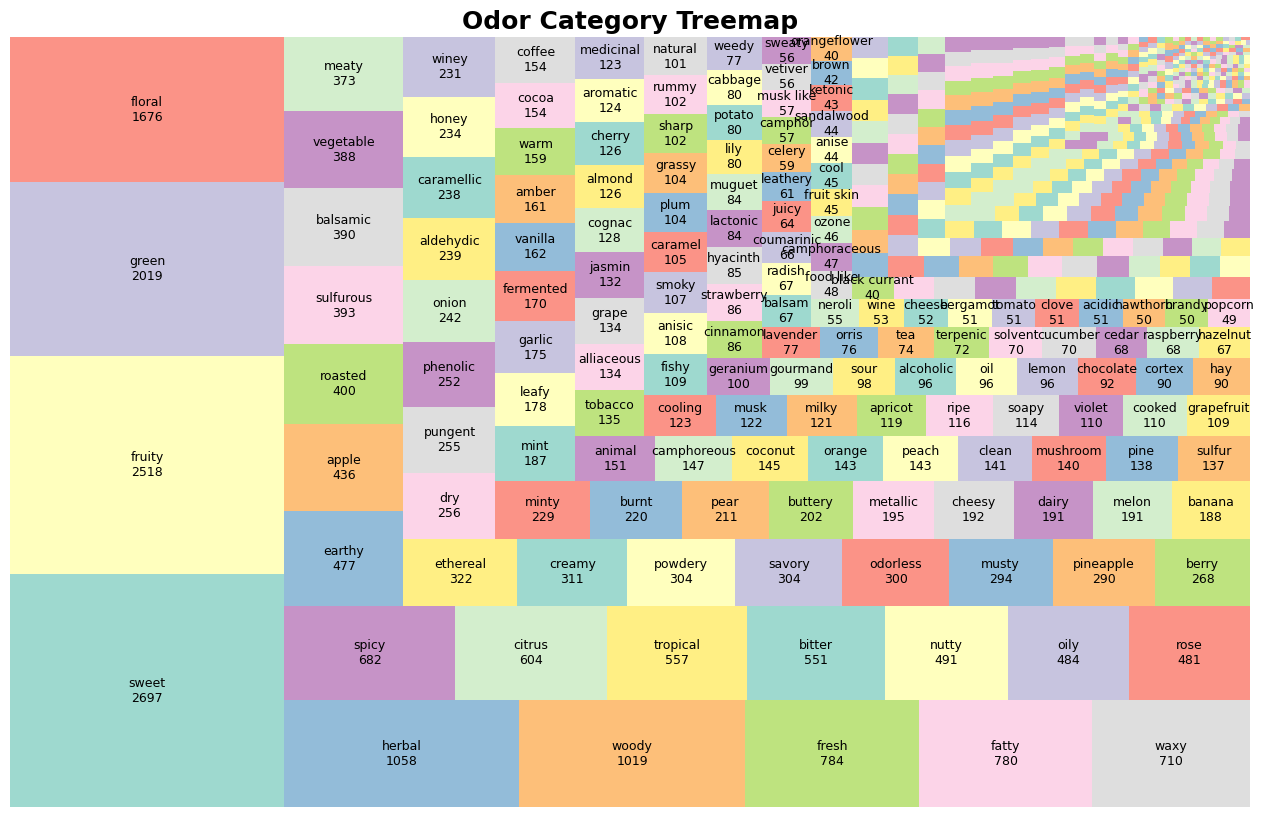

In [37]:
df = pd.read_csv("odor_counts_251214.csv")
df = df.sort_values("count", ascending=False).reset_index(drop=True)

# 调色板
palette = sns.color_palette("Set3", len(df))
colors = [palette[i % len(palette)] for i in range(len(df))]

# 设定一个阈值，只显示前若干大的标签
label_threshold = df["count"].quantile(0.8)  # 只显示排名前 30% 的标签

labels = [
    f"{label}\n{count}"
    if count >= label_threshold else ""
    for label, count in zip(df["odor_labels"], df["count"])
]

plt.figure(figsize=(16, 10))
squarify.plot(
    sizes=df["count"],
    label=labels,
    color=colors,
    alpha=0.85,
    text_kwargs={'fontsize':9}
)
plt.title("Odor Category Treemap", fontsize=18, fontweight='bold')
plt.axis('off')
plt.show()



In [41]:
df =  pd.read_csv("251105_merged_output.csv")

In [42]:
nan_odor_labels = df[df['odor_labels'].isna() & df['odor_threshold'].isna()]
nan_odor_labels = nan_odor_labels[['smiles','cas', 'odor_labels','odor_threshold','source']]
nan_odor_labels.reset_index(drop=True, inplace=True)
#nan_odor_labels.to_csv('nan_odor_labels.csv', index=False)


In [43]:
len(nan_odor_labels)

52

In [44]:
nan_odor_labels

,smiles,cas,odor_labels,odor_threshold,source
0,CCCCCCCOC1C(C(C(C(O1)CO)O)O)O,100231-64-9,NaN,NaN,FlavorDB
1,CC1C(C(C(C(O1)O)O)O)OC2C(C(C(C(O2)CO)OC3C(C(C(...,1024594-90-8,NaN,NaN,FlavorDB
2,C1C(C(OCO1)C2C(COCO2)O)O,10300-97-7,NaN,NaN,FlavorDB
3,C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...,1062-98-2,NaN,NaN,FlavorDB
4,C1=CC=C(C=C1)C[C@@H](C(=O)O)NC(=O)[C@H](CC(=O)...,110697-46-6,NaN,NaN,FlavorDB
5,C[C@]12CC[C@@](C[C@@H]1C3=CC(=O)C4[C@]5(CC[C@@...,111510-20-4,NaN,NaN,FlavorDB
6,CC1=CC/C(=C(/C)\CCC=C(C)C)/CC1,13062-00-5,NaN,NaN,FlavorDB
7,CO[C@H]1[C@@H]([C@H](O[C@@H]([C@@H]1O)O)CO)O,13224-94-7,NaN,NaN,FlavorDB
8,CC1=C2C(=CC(=C1C(=O)O)O)C(=O)C3=C(C2=O)C(=C(C(...,1343-78-8,NaN,NaN,FlavorDB
9,C1[C@@H]([C@@H]([C@H]([C@@H](O1)OC[C@@H]2[C@H]...,14116-69-9,NaN,NaN,FlavorDB


In [45]:
cas_list = df['cas'].tolist()
len(cas_list)

7111

In [51]:
not_none_cas = [cas for cas in cas_list if cas and not pd.isna(cas)]
len(not_none_cas)

6517

In [1]:
import pandas as pd


In [2]:
df_1202 = pd.read_csv('251202_without_NaN.csv')
dict_1202 = df_1202.to_dict(orient='records')
print(len(dict_1202))

7085


In [26]:
count=0
for i in dict_1202:
    if not pd.isna(i['odor_labels']) and 'valley' in i['odor_labels']:
        print(i['smiles'],i['odor_labels'])
        count+=1
print(count)

CC(C)c1cccc(C(C)CC=O)c1 floral,fresh,green,lily of the valley,linden flower,muguet
CC(C)(CO)Cc1ccccc1 floral,lily of the valley,woody
CC(C)=CCCC(C)CCCC(C)C=O aldehydic,floral,fresh,incense,lily of the valley,marine,metallic,nasturtium,rose,soapy,watery,waxy
3


In [3]:
cas_key_dict = {}
smi_key_dict = {}
no_cas_list=[]
no_smiles_list = []
for row in dict_1202:
    cas = row['cas']
    smiles = row['smiles']
    if smiles and not pd.isna(smiles):
        smi_key_dict[smiles] = row
    else:
        no_smiles_list.append(row)
    if cas and not pd.isna(cas):
        cas_key_dict[cas] = row
    else:
        no_cas_list.append(row)

In [4]:
len(no_cas_list),len(cas_key_dict),len(no_smiles_list),len(smi_key_dict)

(594, 6491, 0, 7085)

In [5]:
cas_todo=[]
df_1214 = pd.read_csv('ifra_out_tobe_merged_251214.csv')
tobe_merged = df_1214.to_dict(orient='records')
len(tobe_merged)

2099

In [6]:
for i in tobe_merged:
    if i['cas'] in cas_key_dict:
        if (not cas_key_dict[i['cas']]['odor_labels']) or pd.isna(cas_key_dict[i['cas']]['odor_labels']):
            print(cas_key_dict[i['cas']]['odor_labels'],cas_key_dict[i['cas']]['odor_threshold'])
            merged_odor_labels = []
        else:
            merged_odor_labels = cas_key_dict[i['cas']]['odor_labels'].split(',')
        merged_odor_labels.extend(i['odor_labels'].split(','))
        merged_odor_labels = list(set(merged_odor_labels))
        merged_odor_labels.sort()
        cas_key_dict[i['cas']]['odor_labels'] = ','.join(merged_odor_labels)
    else:
        cas_key_dict[i['cas']] = i
        

nan 0.075
nan 0.72
nan 0.002
nan 0.001
nan 0.5
nan 0.4
nan 0.041
nan 0.043
nan 0.4885
nan 0.0001
nan 0.011
nan 5.0
nan 0.087
nan 0.01
nan 0.15
nan 0.064
nan 0.087
nan 0.52
nan 0.0042
nan 0.006
nan 0.001
nan 0.034
nan 0.92
nan 0.1
nan 0.2
nan 0.01
nan 0.0046
nan 0.03
nan 0.0025
nan 0.075
nan 0.15
nan 0.07
nan 0.039
nan 0.64
nan 0.001
nan 0.13
nan 0.0002
nan 0.21
nan 0.07


In [8]:
dict_1214_out = list(cas_key_dict.values()) + no_cas_list
len(dict_1214_out)

7619

In [9]:
smis= []
for i in dict_1214_out:
    smis.append(i['smiles'])


In [10]:
len(smis),len(set(smis))

(7619, 7516)

In [23]:
smi_key_dict = {}

In [24]:
def is_not_empty(value):
    return value and value != 0 and not pd.isna(value)

In [25]:
for i in dict_1214_out:
    if i['smiles'] not in smi_key_dict:
        smi_key_dict[i['smiles']] = i
    else:
        exist_dict=smi_key_dict[i['smiles']]
        old_labels = exist_dict['odor_labels'].split(',') if is_not_empty(exist_dict['odor_labels']) else []
        new_labels = i['odor_labels'].split(',') if is_not_empty(i['odor_labels']) else []
        odor_labels = ','.join(list(set(old_labels+new_labels)))
        # smiles,cas,iupac,fema,odor_labels,odor_threshold,source,IFRA_name,IFRA
        smi_key_dict[i['smiles']]={
            'smiles':i['smiles'],
            'cas':i['cas'] if is_not_empty(i['cas']) else exist_dict['cas'],
            'fema':i['fema'] if is_not_empty(i['fema']) else exist_dict['fema'],
            'iupac':i['iupac'] if is_not_empty(i['iupac']) else exist_dict['iupac'],
            'odor_labels':odor_labels,
            'odor_threshold':i['odor_threshold'] if is_not_empty(i.get('odor_threshold','')) else exist_dict.get('odor_threshold',''),
            'source':i['source'] if is_not_empty(i['source']) else exist_dict['source'],
            'IFRA_name':i['IFRA_name'] if is_not_empty(i.get('IFRA_name','')) else exist_dict.get('IFRA_name',''),
            'IFRA':i['IFRA'] if is_not_empty(i.get('IFRA','')) else exist_dict.get('IFRA','')
        }


In [26]:
len(smi_key_dict)

7516

In [27]:

df_1214_out = pd.DataFrame(smi_key_dict.values())


In [29]:
df_1214_out.to_csv('251214_merged_out.csv',index=False)

In [43]:
cas_labels_dict_with_cas_key = {}
for i in cas_labels_list:
    cas= i['cas'].replace('/','-')
    curr_labels = list(set([i['label1'],i['label2'],i['label3']]))
    if cas not in cas_labels_dict_with_cas_key:
        cas_labels_dict_with_cas_key[cas] = []
    cas_labels_dict_with_cas_key[cas].extend(curr_labels)
    cas_labels_dict_with_cas_key[cas]=list(set(cas_labels_dict_with_cas_key[cas]))
    if len(cas_labels_dict_with_cas_key[cas]) < 3:
        print('length < 3',cas_labels_dict_with_cas_key[cas],cas)
    if len(cas_labels_dict_with_cas_key[cas]) > 3:
        print('length > 3',cas_labels_dict_with_cas_key[cas],cas)

len(cas_labels_dict_with_cas_key)


length < 3 ['Ozonic', 'Citrus'] 112-45-8
length < 3 ['Nutty', 'Gourmand'] 18138-04-0
length > 3 ['Woody', 'Amber', 'Peppery', 'Herbal', 'Spicy'] 8015-64-3
length > 3 ['Woody', 'Amber', 'Fresh', 'Peppery', 'Herbal', 'Spicy', 'Pungent'] 8015-64-3
length > 3 ['Fresh', 'Green', 'Apple', 'Fruity'] 883111-87-3
length > 3 ['Aromatic', 'Herbal', 'Spicy', 'Green'] 8015-73-4
length > 3 ['Aromatic', 'Herbal', 'Spicy', 'Floral', 'Green'] 8015-73-4
length > 3 ['Woody', 'Cinnamon', 'Spicy', 'Sweet'] 8007-80-5
length > 3 ['Aromatic', 'Woody', 'Cedarwood', 'Herbal', 'Pungent'] 8007-20-3
length > 3 ['Woody', 'Cedarwood', 'Dry', 'Balsamic', 'Floral'] 1159574-01-2
length > 3 ['Fruity', 'Medicinal', 'Warm', 'Herbal', 'Sweet'] 8002-66-2
length > 3 ['Earthy', 'Chamomile', 'Fruity', 'Medicinal', 'Warm', 'Herbal', 'Sweet'] 8002-66-2
length > 3 ['Aromatic', 'Herbal', 'Chamomile', 'Fruity'] 8015-92-7
length > 3 ['Fruity', 'Fresh', 'Gardenia', 'Herbal', 'Floral'] 8006-76-6
length > 3 ['Aromatic', 'Fruity', 'Fres

2509

In [44]:
import sys,httpx,asyncio,time
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

In [45]:
from src.utils.robot import get_dict_from_cas,main_use

In [87]:
time_start = time.time()
sem = asyncio.Semaphore(20)
results=[]
error_list=[]
async with httpx.AsyncClient() as client:
    tasks = [
        get_dict_from_cas(cas,client,sem,error_list)
        for cas in cas_todo
    ]
    results = await asyncio.gather(*tasks)
time_end = time.time()
print(len(results),time_end-time_start)

[111510-20-4] opl page not found (status 404)
[14116-69-9] opl page not found (status 404)
[10300-97-7] opl page not found (status 404)
[13224-94-7] opl page not found (status 404)
[23583-49-5] opl page not found (status 404)
[3146-50-7] opl page not found (status 404)
[1343-78-8] opl page not found (status 404)
[15716-02-6] opl page not found (status 404)
[50410-18-9] opl page not found (status 404)
[35812-01-2] opl page not found (status 404)
[36256-85-6] opl page not found (status 404)
[352-32-9] opl page not found (status 404)
[5349-37-1] opl page not found (status 404)
[16669-42-4] opl page not found (status 404)
[544-13-8] opl page not found (status 404)
[56633-51-3] opl page not found (status 404)
[24121-00-4] opl page not found (status 404)
[64011-61-6] opl page not found (status 404)
[6622-52-2] opl page not found (status 404)
[110697-46-6] opl page not found (status 404)
[1024594-90-8] opl page not found (status 404)
[24667-52-5] opl page not found (status 404)
[22839-65-2] o

In [79]:
for i in results_with_smiles:
    cas = i['cas']
    if isinstance(i['odor_labels'], str):
        i['odor_labels'] = [w.strip().lower() for w in i['odor_labels'].split(',') if w.strip()]
    i['odor_labels'] = ','.join(list(set(i['odor_labels'] + [i.lower() for i in cas_labels_dict_with_cas_key[cas]])))

In [81]:
df_251214 = pd.DataFrame(results_with_smiles)
df_251214.to_csv('ifra_out_tobe_merged_251214.csv',index=False)

In [28]:
from copy import deepcopy
result_post = []
for item in results:
    i = deepcopy(item)
    if i['smiles'] and i['odor_labels']:
        i['odor_labels'] = ','.join(i['odor_labels'])
        result_post.append(i)
    else:
        print(i['cas'])

124-41-4
10300-97-7
21368-68-3
56633-51-3
111510-20-4
73018-51-6
50410-18-9
544-13-8
134849-13-1
118-56-9
563-47-3
33210-23-4
629-73-2
54464-59-4
68917-18-0
77-73-6
7722-84-1
3239-35-8
1214625-91-8
2563-7-7
1686-14-2
71116-59-1
24199-46-0
929625-08-1
24667-52-5
2571619
13062-00-5
1993-8-3
352-32-9
57566-26-4
28897-21-4
124358-45-8
18309-32-5
4090-11-8
69542-91-2
147060-73-10
1560-95-8
110-27-0
1993-4-9
36256-85-6
110697-46-6
9004-39-1
112-38-9
5726-19-2
35812-01-2
68-91-7
5560-59-8
6814-36-4
90480-35-6
13224-94-7
1979-9-4
140-55-2
10191-41-0
5392-40-5
22839-65-2
16669-42-4
28447-39-4
1343-78-8
3146-50-7
106-31-0
100231-64-9
1960-12-8
96-47-9
372-09-8
60335-74-2
24851-98-7
68956-56-9
4618-18-2
60842-51-5
64011-61-6
68155-67-9
5462-6-6
2305-5-7
154171-77-4
68489-14-5
51330-27-9
19894-99-6
556-02-5
1117-31- 3
52-89-1
110418
23583-49-5
747-36-4
87-96-7
116126-82-0
111-21-7
1024594-90-8
25395-31-7
99-20-7
3458-28-4
54-91-3
5349-37-1
1996-9-3
6622-52-2
3243-36-5
92117-27-6
24121-00-4
26218-0

In [29]:
len(result_post)

438

In [30]:
result_post[1]

{'cas': '65443-14-3',
 'fema': None,
 'iupac': '2,2,5-trimethyl-5-pentylcyclopentan-1-one',
 'smiles': 'CCCCCC1(C)CCC(C)(C)C1=O',
 'odor_labels': 'apricot,fruity,herbal,jasmin,lactonic,lavender,peach',
 'source': 'wanhua'}

In [41]:
for i in result_post:
    if i['cas'] in cas_key_dict:
        cas_key_dict[i['cas']]['odor_labels'] = i['odor_labels']
        print(f"update: {i['cas']}")
    else:
        i['odor_threshold']=None
        i['IFRA_name'] = None
        i['IFRA'] = None
        cas_key_dict[i['cas']] = i

update: 18127-01-0
update: 65443-14-3
update: 90-17-5
update: 54440-17-4
update: 137-00-8
update: 123-92-2
update: 69300-15-8
update: 68901-32-6
update: 101-84-8
update: 23911-56-0
update: 198404-98-7
update: 115-99-1
update: 950-33-4
update: 106-21-8
update: 65113-99-7
update: 93-92-5
update: 59259-38-0
update: 2623-23-6
update: 1365-19-1
update: 63314-79-4
update: 112-45-8
update: 106-72-9
update: 150-84-5
update: 102-20-5
update: 81-14-1
update: 69-72-7
update: 58296-81-4
update: 103-53-7
update: 66576-71-4
update: 91-51-0
update: 61792-11-8
update: 142-19-8
update: 100-06-1
update: 475-20-7
update: 55066-48-3
update: 81925-81-7
update: 14765-30-1
update: 8000-41-7
update: 22457-23-4
update: 141773-73-1
update: 123-72-8
update: 6290-17-1
update: 107-75-5
update: 106-68-3
update: 21834-92-4
update: 77-53-2
update: 25225-10-9
update: 57934-97-1
update: 118-60-5
update: 89-43-0
update: 18871-14-2
update: 13477-62-8
update: 23726-91-2
update: 14073-97-3
update: 236391-76-7
update: 66327

In [42]:
vals = list(cas_key_dict.values())
print(len(vals))

6563


In [43]:
vals[:10]

[{'smiles': 'O=[N+]([O-])c1ccc(O)cc1',
  'cas': '100-02-7',
  'iupac': '4-nitrophenol',
  'fema': nan,
  'odor_labels': nan,
  'odor_threshold': 2.5,
  'source': 'Threshold',
  'IFRA_name': nan,
  'IFRA': nan},
 {'smiles': 'COc1ccc(C(C)=O)cc1',
  'cas': '100-06-1',
  'iupac': '1-(4-methoxyphenyl)ethanone',
  'fema': 2005.0,
  'odor_labels': 'acacia,anisic,balsamic,cherry,cherry maraschino cherry,fruity,hawthorn,powdery,sweet,vanilla',
  'odor_threshold': nan,
  'source': 'GS-LF',
  'IFRA_name': nan,
  'IFRA': nan},
 {'smiles': 'COc1ccc(C(=O)O)cc1',
  'cas': '100-09-4',
  'iupac': '4-methoxybenzoic acid',
  'fema': 3945.0,
  'odor_labels': 'animal,cherry,medicinal,phenolic,spicy,sweet,vanilla',
  'odor_threshold': nan,
  'source': 'GS-LF',
  'IFRA_name': nan,
  'IFRA': nan},
 {'smiles': 'CCc1ccccc1',
  'cas': '100-41-4',
  'iupac': 'ethylbenzene',
  'fema': nan,
  'odor_labels': 'bitter',
  'odor_threshold': 0.0024,
  'source': 'Threshold',
  'IFRA_name': nan,
  'IFRA': nan},
 {'smiles'

In [46]:
smi_key_dict={}
for i in vals:
    smi_key_dict[i['smiles']]=i

In [49]:
for i in no_cas_list:
    if i['smiles'] not in smi_key_dict:
        smi_key_dict[i['smiles']] = i
    else:
        print(i)

In [50]:
vals_post = list(smi_key_dict.values())
len(vals_post)

7135

In [51]:
vals_post[:5]

[{'smiles': 'O=[N+]([O-])c1ccc(O)cc1',
  'cas': '100-02-7',
  'iupac': '4-nitrophenol',
  'fema': nan,
  'odor_labels': nan,
  'odor_threshold': 2.5,
  'source': 'Threshold',
  'IFRA_name': nan,
  'IFRA': nan},
 {'smiles': 'COc1ccc(C(C)=O)cc1',
  'cas': '100-06-1',
  'iupac': '1-(4-methoxyphenyl)ethanone',
  'fema': 2005.0,
  'odor_labels': 'acacia,anisic,balsamic,cherry,cherry maraschino cherry,fruity,hawthorn,powdery,sweet,vanilla',
  'odor_threshold': nan,
  'source': 'GS-LF',
  'IFRA_name': nan,
  'IFRA': nan},
 {'smiles': 'COc1ccc(C(=O)O)cc1',
  'cas': '100-09-4',
  'iupac': '4-methoxybenzoic acid',
  'fema': 3945.0,
  'odor_labels': 'animal,cherry,medicinal,phenolic,spicy,sweet,vanilla',
  'odor_threshold': nan,
  'source': 'GS-LF',
  'IFRA_name': nan,
  'IFRA': nan},
 {'smiles': 'CCc1ccccc1',
  'cas': '100-41-4',
  'iupac': 'ethylbenzene',
  'fema': nan,
  'odor_labels': 'bitter',
  'odor_threshold': 0.0024,
  'source': 'Threshold',
  'IFRA_name': nan,
  'IFRA': nan},
 {'smiles'

In [52]:
save_df = pd.DataFrame(vals_post)
save_df.to_csv('251202_merged.csv', index=False)

In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import xlsxwriter
from io import BytesIO

# ========= 参数 =========
input_csv = "data/filter_muguet_21.csv"
output_xlsx = "data/output_with_rdkit_images.xlsx"
img_size = (250, 250)
image_col_name = "rdkit_2d_structure"

# ========= 读取 CSV =========
df = pd.read_csv(input_csv)

# ========= 创建 Excel =========
workbook = xlsxwriter.Workbook(output_xlsx)
worksheet = workbook.add_worksheet("data")

# 写表头
for col_idx, col_name in enumerate(df.columns):
    worksheet.write(0, col_idx, col_name)

img_col_idx = len(df.columns)
worksheet.write(0, img_col_idx, image_col_name)

# ========= 写数据 + 图片 =========
for row_idx, row in df.iterrows():
    excel_row = row_idx + 1

    # 普通字段
    for col_idx, value in enumerate(row):
        worksheet.write(excel_row, col_idx, value)

    smiles = row["smiles"]
    mol = Chem.MolFromSmiles(smiles)

    if mol:
        img = Draw.MolToImage(mol, size=img_size)

        # 保存到内存
        image_data = BytesIO()
        img.save(image_data, format="PNG")
        image_data.seek(0)

        # 插入图片
        worksheet.insert_image(
            excel_row,
            img_col_idx,
            "mol.png",
            {
                "image_data": image_data,
                "x_scale": 1,
                "y_scale": 1,
                "object_position": 1,  # 图片随单元格移动/缩放
            },
        )

        # 调整行高 / 列宽
        worksheet.set_row(excel_row, 150)
        worksheet.set_column(img_col_idx, img_col_idx, 35)

# ========= 保存 =========
workbook.close()
print(f"完成：已生成 {output_xlsx}")


完成：已生成 data/output_with_rdkit_images.xlsx


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import xlsxwriter
from io import BytesIO

# ========= 参数 =========
input_csv = "data/filter_iris.csv"
output_xlsx = "data/filter_iris_images.xlsx"
img_size = (250, 250)
image_col_idx = 1                # 第二列（0-based）
image_col_name = "2d_structure"

# ========= 读取 CSV =========
df = pd.read_csv(input_csv)

# ========= 创建 Excel =========
workbook = xlsxwriter.Workbook(output_xlsx)
worksheet = workbook.add_worksheet("data")

# ========= 写表头 =========
worksheet.write(0, 0, df.columns[0])       # 第一列
worksheet.write(0, image_col_idx, image_col_name)

for i, col in enumerate(df.columns[1:], start=2):
    worksheet.write(0, i, col)

# ========= 写数据 + 图片 =========
for row_idx, row in df.iterrows():
    excel_row = row_idx + 1

    # 第一列（如 smiles）
    worksheet.write(excel_row, 0, row.iloc[0])

    # 其余普通列整体右移一列
    for col_idx, value in enumerate(row.iloc[1:], start=2):
        worksheet.write(excel_row, col_idx, value)

    # ===== 画分子图 =====
    mol = Chem.MolFromSmiles(row["smiles"])
    if mol:
        img = Draw.MolToImage(mol, size=img_size)

        img_data = BytesIO()
        img.save(img_data, format="PNG")
        img_data.seek(0)

        worksheet.insert_image(
            excel_row,
            image_col_idx,
            "mol.png",
            {
                "image_data": img_data,
                "object_position": 1,  # 随单元格移动缩放
            },
        )

        # 行高 / 列宽
        worksheet.set_row(excel_row, 150)
        worksheet.set_column(image_col_idx, image_col_idx, 35)

# ========= 保存 =========
workbook.close()
print(f"完成：图片已插入第二列 -> {output_xlsx}")


完成：图片已插入第二列 -> data/filter_iris_images.xlsx


In [2]:
import pandas as pd
from rdkit import Chem
import pandas as pd

# 过渡金属 + 碱金属/碱土金属 + 常见后过渡金属（可按需增减）
METALS = {
    "Li","Na","K","Rb","Cs","Fr",
    "Be","Mg","Ca","Sr","Ba","Ra",
    "Sc","Ti","V","Cr","Mn","Fe","Co","Ni","Cu","Zn",
    "Y","Zr","Nb","Mo","Tc","Ru","Rh","Pd","Ag","Cd",
    "Hf","Ta","W","Re","Os","Ir","Pt","Au","Hg",
    "Al","Ga","In","Tl","Sn","Pb","Bi","Sb",
    "La","Ce","Pr","Nd","Pm","Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm","Yb","Lu",
    "Ac","Th","Pa","U","Np","Pu","Am","Cm","Bk","Cf","Es","Fm","Md","No","Lr",
}

def has_metal(smiles: str, only_ions: bool = False) -> bool:
    if smiles is None or (isinstance(smiles, float) and pd.isna(smiles)):
        return False
    mol = Chem.MolFromSmiles(str(smiles))
    if mol is None:
        return False
    for atom in mol.GetAtoms():
        if atom.GetSymbol() in METALS:
            if only_ions:
                if atom.GetFormalCharge() != 0:
                    return True
            else:
                return True
    return False

In [6]:
df_no_metal = pd.read_csv('./data/260125_merged_no_metal_with_marine.csv')

In [7]:
has_metal = df_251214["smiles"].apply(lambda s: has_metal(s))


[16:01:39] WARNING: not removing hydrogen atom without neighbors
[16:01:39] WARNING: not removing hydrogen atom without neighbors
[16:01:39] WARNING: not removing hydrogen atom without neighbors
[16:01:39] WARNING: not removing hydrogen atom without neighbors


In [14]:
df_no_metal = df_251214[~has_metal].reset_index(drop=True)
len(df_no_metal)

7345

In [15]:
df_no_metal[:10]

,smiles,cas,iupac,fema,odor_labels,odor_threshold,source,IFRA_name,IFRA
0,O=[N+]([O-])c1ccc(O)cc1,100-02-7,4-nitrophenol,NaN,NaN,2.5000,Threshold,NaN,NaN
1,COc1ccc(C(C)=O)cc1,100-06-1,1-(4-methoxyphenyl)ethanone,2005.0,"acacia,anisic,balsamic,cherry,cherry maraschin...",NaN,GS-LF,NaN,NaN
2,COc1ccc(C(=O)O)cc1,100-09-4,4-methoxybenzoic acid,3945.0,"animal,animal like,cherry,fecal,leathery,medic...",NaN,GS-LF,NaN,NaN
3,CCc1ccccc1,100-41-4,ethylbenzene,NaN,bitter,0.0024,Threshold,NaN,NaN
4,C=Cc1ccccc1,100-42-5,styrene,NaN,"almond,balsamic,floral,fruity,green,minty,plas...",0.0120,Threshold,NaN,NaN
5,NCc1ccccc1,100-46-9,phenylmethanamine,NaN,NaN,3.0000,Threshold,NaN,NaN
6,N#Cc1ccccc1,100-47-0,benzonitrile,NaN,"almond,bitter,cherry,fruity,gourmand,minty,nut...",NaN,GS-LF,NaN,NaN
7,C1CCC(CC1)CO,100-49-2,cyclohexylmethanol,NaN,"cheese,dairy,sour",NaN,FlavorDB,NaN,NaN
8,OCc1ccccc1,100-51-6,phenylmethanol,2137.0,"almond,balsamic,bitter,chemical,cherry,floral,...",0.1000,Threshold,"""Benzyl alcohol""",Restriction
9,O=Cc1ccccc1,100-52-7,benzaldehyde,2127.0,"almond,bitter,cherry,cherry maraschino cherry,...",NaN,GS-LF,"""Benzaldehyde""",Restriction


In [7]:
label_todo = ["ozonic", "ozone","wet", "seaweed", "seashore", "watery", "watermelon", "watermelon rind", "cucumber"]



In [8]:
def _normalize_labels(s: str) -> list[str]:
    if s is None or (isinstance(s, float) and pd.isna(s)):
        return []
    parts = [p.strip() for p in str(s).split(",")]
    return [p for p in parts if p]

todo_set = {x.strip().lower() for x in label_todo}
target_label = "marine"

def _should_add_marine(odor_labels: str) -> bool:
    labels = {x.lower() for x in _normalize_labels(odor_labels)}
    return (target_label not in labels) and (len(labels & todo_set) > 0)

mask_add = df_no_metal["odor_labels"].apply(_should_add_marine)

def _add_marine(odor_labels: str) -> str:
    labels = _normalize_labels(odor_labels)
    lower = {x.lower() for x in labels}
    if target_label not in lower:
        labels.append(target_label)
    # 去重（保留原顺序）
    seen = set()
    out = []
    for x in labels:
        k = x.lower()
        if k not in seen:
            seen.add(k)
            out.append(x)
    return ",".join(out)

df_no_metal.loc[mask_add, "odor_labels"] = df_no_metal.loc[mask_add, "odor_labels"].apply(_add_marine)

print("需要添加 marine 的行数:", int(mask_add.sum()))


需要添加 marine 的行数: 57


In [9]:
df_no_metal.to_csv('./data/260127_no_metal_with_marine.csv', index=False)

In [61]:
smiles = df_no_metal['smiles'].tolist()
len(smiles), len(set(smiles))

(7341, 7341)

In [62]:
csmi = [Chem.CanonSmiles(smi) for smi in smiles]

In [63]:
len(csmi), len(set(csmi))

(7341, 7341)

In [64]:
# ...existing code...
csmi_to_first_idx: dict[str, int] = {}

for i, smi in enumerate(smiles):
    csmi = Chem.CanonSmiles(smi)
    if csmi in csmi_to_first_idx:
        first_i = csmi_to_first_idx[csmi]
        print(f"重复 canonical_smiles: {csmi} | first_index={first_i}, dup_index={i} | dup_smiles={smi}")
    else:
        csmi_to_first_idx[csmi] = i
# ...existing code...
    

In [39]:
df_no_metal.loc[[1183,5921],].to_dict()

{'smiles': {1183: 'CC(C)[C@@H]1CC[C@@H](C)CC1=O',
  5921: 'C[C@@H]1CC[C@H](C(=O)C1)C(C)C'},
 'cas': {1183: '14073-97-3', 5921: '89-80-5'},
 'iupac': {1183: 'trans-(2S,5R)-5-methyl-2-propan-2-ylcyclohexan-1-one',
  5921: '(2S,5R)-5-methyl-2-propan-2-ylcyclohexan-1-one'},
 'fema': {1183: 2667.0, 5921: 2667.0},
 'odor_labels': {1183: 'anise,camphoreous,cooling,fresh,green,herbal,mentholic,minty,peppermint,sweet',
  5921: 'cooling,herbal,mentholic,minty,spearmint,spicy,sweet,warm,woody'},
 'odor_threshold': {1183: nan, 5921: nan},
 'source': {1183: 'wanhua', 5921: 'FlavorDB'},
 'IFRA_name': {1183: nan, 5921: nan},
 'IFRA': {1183: nan, 5921: nan}}

In [48]:
','.join(set(df_no_metal.loc[1183,'odor_labels'].split(',') + df_no_metal.loc[5921,'odor_labels'].split(',')))

'green,spearmint,cooling,anise,camphoreous,herbal,peppermint,mentholic,fresh,woody,spicy,minty,sweet,warm'

In [49]:
df_no_metal.loc[1183,'odor_labels'] = ','.join(set(df_no_metal.loc[1183,'odor_labels'].split(',') + df_no_metal.loc[5921,'odor_labels'].split(',')))

In [51]:
df_no_metal.drop(index=5921, inplace=True)
df_no_metal.loc[1183,'odor_labels']

'green,spearmint,cooling,anise,camphoreous,herbal,peppermint,mentholic,fresh,woody,spicy,minty,sweet,warm'

In [40]:
df_no_metal.loc[[71,6459],].to_dict()

{'smiles': {71: 'CCCCCC/C(=C\\C1=CC=CC=C1)/C=O',
  6459: 'CCCCCC/C(C=O)=C\\c1ccccc1'},
 'cas': {71: '101-86-0', 6459: '165184-98-5'},
 'iupac': {71: '(2E)-2-benzylideneoctanal', 6459: '(2E)-2-benzylideneoctanal'},
 'fema': {71: 2569.0, 6459: 2569.0},
 'odor_labels': {71: 'citrus,floral,fresh,fruity,green,herbal,jasmin,powdery,spicy,sweet,tropical,waxy',
  6459: 'citrus,floral,jasmin'},
 'odor_threshold': {71: nan, 6459: nan},
 'source': {71: 'FlavorDB', 6459: 'wanhua'},
 'IFRA_name': {71: '"alpha-Hexyl cinnamic aldehyde"', 6459: nan},
 'IFRA': {71: 'Restriction', 6459: nan}}

In [53]:
df_no_metal.drop(index=6459, inplace=True)

In [42]:
df_no_metal.loc[[3162,6602],].to_dict()


{'smiles': {3162: 'C1=CC=C(C=C1)/C=C/C#N', 6602: 'N#C/C=C/c1ccccc1'},
 'cas': {3162: '4360-47-8', 6602: '1885-38-7'},
 'iupac': {3162: '(E)-3-phenylprop-2-enenitrile',
  6602: '(E)-3-phenylprop-2-enenitrile'},
 'fema': {3162: nan, 6602: nan},
 'odor_labels': {3162: 'cassia,cinnamon,floral,spicy,sweet',
  6602: 'cinnamon,cumin,spicy,cassia,metallic'},
 'odor_threshold': {3162: nan, 6602: nan},
 'source': {3162: 'FlavorDB', 6602: 'wanhua'},
 'IFRA_name': {3162: '"Cinnamyl nitrile"', 6602: nan},
 'IFRA': {3162: 'Restriction', 6602: nan}}

In [55]:
merged_labels = ','.join(set(df_no_metal.loc[3162,'odor_labels'].split(',') + df_no_metal.loc[6602,'odor_labels'].split(',')))
df_no_metal.loc[3162,'odor_labels'] = merged_labels
df_no_metal.drop(index=6602, inplace=True)

In [43]:
df_no_metal.loc[[5178,6703],].to_dict()


{'smiles': {5178: 'CC1=CC[C@H](C[C@H]1OC(=O)C)C(=C)C',
  6703: 'C=C(C)[C@@H]1CC=C(C)[C@H](OC(C)=O)C1'},
 'cas': {5178: '7111-29-7', 6703: '1205-42-1'},
 'iupac': {5178: '[(1R,5R)-2-methyl-5-prop-1-en-2-ylcyclohex-2-en-1-yl] acetate',
  6703: '[(1R,5R)-2-methyl-5-prop-1-en-2-ylcyclohex-2-en-1-yl] acetate'},
 'fema': {5178: nan, 6703: nan},
 'odor_labels': {5178: 'woody', 6703: 'fresh,minty,dry'},
 'odor_threshold': {5178: nan, 6703: nan},
 'source': {5178: 'FlavorDB', 6703: 'wanhua'},
 'IFRA_name': {5178: nan, 6703: nan},
 'IFRA': {5178: nan, 6703: nan}}

In [56]:
df_no_metal.loc[5178,'odor_labels'] = 'fresh,minty,dry,woody'

In [58]:
df_no_metal.drop(index=6703, inplace=True)

KeyError: '[6703] not found in axis'

In [59]:
df_no_metal.reset_index(drop=True, inplace=True)

In [65]:
# ...existing code...

def _canon_or_none(s):
    if s is None or (isinstance(s, float) and pd.isna(s)):
        return None
    s = str(s).strip()
    if not s:
        return None
    try:
        return Chem.CanonSmiles(s)
    except Exception:
        return None  # 非法 smiles

df_no_metal["smiles"] = df_no_metal["smiles"].apply(_canon_or_none)

# 可选：看看有多少被转成 None（非法/空）
print("smiles 为空/非法数量:", int(df_no_metal["smiles"].isna().sum()))
# ...existing code...

smiles 为空/非法数量: 0


In [66]:
df_no_metal.to_csv('./data/260125_merged_no_metal_with_marine.csv', index=False)